<a href="https://colab.research.google.com/github/Alven8816/DEEPER_with_R_workshop_20220908/blob/main/DEEPER_R_workshop_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep ensemble machine learning (DEML) for estimating environmental exposure - Session 2**

Wenhua(Alven) Yu; Liam Liu

2022-09-08

In [ ]:
# check the package installation
install.packages("pacman")
library(pacman)
p_load("devtools","SuperLearner","ranger","CAST","caret","skimr","gbm","xgboost","hexbin")
# about 9 minutes

# R package 'deeper' install

Before installation, please make sure:

-   using R (\>= 3.5.0)

-   installed certain dependent R packages: devtools, SuperLearner(\>= 2.0-28)

-   installed other suggested R packages: caret, skimr, CAST, ranger, gbm, xgboost, (nnls, foreach,splines, gam)


The developing version of deeper can be found from [github](https://github.com/Alven8816/deeper).

Using the following syntax to install:

``` {.r}
library(devtools)
install_github("Alven8816/deeper")
```

In [3]:
library(devtools)

In [ ]:
install_github("Alven8816/deeper")

In [ ]:
library(deeper)

# Activity

Getting access to the Google Colab or install deeper R package in your local computer.


# Basic steps for DEML

* **Step 1.  Data preparation**

Including data collection, data clean, setting trianing and testing dataset, and independent variables selection.

**Note: DEML could not directly deal with missing values and missing value imputation technologies is recommended prior to the use of the DEML model.**

    
* **Step 2.  Establish base models**

Using predictModel() or predictModel_parallel() to establish the base models. A tuningModel() function can be used to tuning the parameters to get the best single base model.

* **Step 3.  Stacking meta models**

We use stack_ensemble(),stack_ensemble.fit(), or stack_ensemble_parallel() function to stack the meta models to get a DEML model.


* **Step 4.  Prediction based on new data set**

After establishment of DEML model, the predict() can be used predict the unseen data set.

To assess the performance of the models, assess.plot() can be used by comparing the original observations (y in test set) and the prediction. The assess.plot() also return the point scatter plot.


# Algorithms selection

In [6]:
data(model_list)
print(model_details)

# A tibble: 35 × 4
   parameter          algorithm                                  require…¹ types
   <chr>              <chr>                                     <chr>      <chr>
 1 SL.bayesglm        Bayesian generalized linear regression    arm        R    
 2 SL.biglasso        Extending Lasso Model Fitting to Big Data biglasso   R    
 3 SL.caret           random Forest as default                  caret      R    
 4 SL.caret.rpart     decision trees as default                 caret      R    
 5 SL.cforest         Breiman's random forests                  party      R    
 6 SL.earth           Multivariate Adaptive Regression Splines  earth      R    
 7 SL.gam             generalized additive models               gam        N    
 8 SL.gbm             generalized boosting algorithm            gbm        R    
 9 SL.glm             generalized linear models                 NA         R    
10 SL.glm.interaction generalized linear models                 NA         R    
# … with 

In the 'type' column, "R": can be used for regression or classification;"N": can be used for regression but variables require to be numeric style; "C": just used in classification.


# Example

*To estimate the daily ambient PM2.5 in the northeast of China in 2015-2016.*

## 1.Data preparation

In [7]:
data("envir_example")

knitr::kable(head(envir_example))



|date      |code  |year |month |week |     PM2.5|     c_AOD|      TEMP|        AP|       RH| elevation|        WS| a_buffer10|
|:---------|:-----|:----|:-----|:----|---------:|---------:|---------:|---------:|--------:|---------:|---------:|----------:|
|2/01/2015 |1001A |2015 |1     |5    |  51.26087| 0.2191133| -2.757819| 1012.1792| 30.50154|        45| 1.6981146|         68|
|3/01/2015 |1001A |2015 |1     |6    | 154.04167| 0.9245346| -3.757023| 1000.7333| 43.59143|        45| 0.9536832|         68|
|4/01/2015 |1001A |2015 |1     |0    | 151.91667| 0.3927248| -1.298150|  999.6592| 43.22169|        45| 1.3580554|         68|
|6/01/2015 |1001A |2015 |1     |2    |  39.54545| 0.3009302| -2.218822| 1010.8966| 20.39437|        45| 2.7473587|         68|
|8/01/2015 |1001A |2015 |1     |4    | 148.38095| 1.0532465| -3.522646| 1012.8126| 54.77821|        45| 1.1803217|         68|
|9/01/2015 |1001A |2015 |1     |5    |  87.78261| 0.1762094| -1.593402| 1011.9749| 37.70417|        45| 2.180

## 1.1 Data clean

The basic data clean strategies include:

1.  Variable type setting

2.  Extreme value (outliers) detection

3.  Missing value operation (imputation, drop)

4.  Data transforming (normalization/standardization, eg. scale, centralize,log-transform and others)

``` {.r}
# skim the data missing value and distribmution
skimr::skim(envir_example)
```


In [8]:
dis_test <- skimr::skim(envir_example)

print(head(dis_test,10))

── Data Summary ────────────────────────
                           Values       
Name                       envir_example
Number of rows             2970         
Number of columns          13           
_______________________                 
Column type frequency:                  
  character                1            
  factor                   4            
  numeric                  5            
________________________                
Group variables            None         

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 date                  0             1   9  10     0      501          0

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 code                  0             1 FALSE          7
2 year                  0             1 FALSE          2
3 month                 0

$character

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 date                  0             1   9  10     0      501          0

$factor

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts             
1 code                  0             1 FALSE          7 100: 436, 100: 432, 10…
2 year                  0             1 FALSE          2 201: 1511, 201: 1459   
3 month                 0             1 FALSE         12 3: 316, 1: 309, 4: 289…
4 week                  0             1 FALSE          7 2: 445, 4: 439, 1: 435…

$numeric

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_…¹ n_mis…² compl…³    mean     sd       p0     p25     p50     p75   p100
1 PM2.5         0       1  70.9   65.2     4.62    23.9    52.3   9.79e+1 4.5 e2
2 c_AOD         0       1   0.674  0.673   0.0212   0.219   0.412 8.87e-1 3.56e0
3 TEMP          0       1  11.3   11.3   -12.1      0.114  12.7   2.19e+1 3.15e1
4 AP            0       1 995.    18.3   939.     989.    998.    1.01e+3 1.03e3
5 RH            0       1  50.6   17.3     9.73    37.1    50.2   6.50e+1 8.88e1
# … with 1 more variable: hist <chr>, and abbreviated variable names
#   ¹​skim_variable, ²​n_missing, ³​complete_rate

## 1.2 Data split

We randomly select 20% of the data as independent testing dataset, and the remainder were used as the training dataset.

The split strategy is based on the size of your sample as well as your question.

In [13]:
set.seed(1234) # to achieve a repeatable resultsm

size <-
  caret::createDataPartition(y = envir_example$PM2.5,
                             p = 0.8, list = FALSE)
trainset <- envir_example[size, ]
testset <- envir_example[-size, ]

Identify the dependence and independence variables

In [12]:
y <- c("PM2.5")
x <- colnames(envir_example[-c(1, 6)]) # except "date" and "PM2.5"

# Challenging 1

Q: Estimate annual average NO2 in Sydney in 2005-2018

* **Data prepare:** Download and load the Sydney NO2 data "data_Sydney.csv" in Google COlab by steps:

Click file in the left side >  Upload to session storage > choose the files > OK


Tasks:

1.  Setting the dependence ("no2_annual") and others as independent variables

2.  Split 10% of data as testing data set


In [9]:
data_Sydney <- read.csv("training_data.csv")

print(head(data_Sydney))

  no2_annual year lon_metres lat_metres pos_elevation pos_distocean
1   4.177732 2018    1723117   -3882593    -0.5442945   -0.72716631
2   2.126907 2018    1720247   -3885163    -0.4352400   -0.68964094
3   7.382676 2018    1723137   -3812193    -0.3289075   -0.08954413
4   7.449784 2018    1748317   -3836653    -0.3607902   -0.56363717
5   4.667771 2018    1746639   -3838431    -0.4601858   -0.56833557
6   4.142557 2018    1717309   -3843953     0.1178904   -0.37247337
  pop_dens_10000 em_rds_dist em_majrd_invdist em_minrd_invdist
1     -0.8558457  -0.1875875       -0.3599888       0.07511178
2     -0.8357406  -0.1862169       -0.3603637      -0.17618748
3     -0.4192745  -0.3529771       -0.2655858       0.07728530
4      1.1338605  -0.4928812        1.6177096      -0.30281745
5      0.8316091   0.7726193       -0.4257326      -0.24915084
6     -0.7026833   0.4792773       -0.4192363      -0.25892256
  em_majrd_length_200 em_minrd_length_50 lc_water_modis_2000 lu_com_5000
1         

In [10]:
# data clean

data_Sydney$year <- as.factor(data_Sydney$year)

# dataset split


## 2. Establish base models

## 2.1 Single base model training

Q: How to select the best parameter for a single base model?


We can set or adjust the parameters of a base model using 'tuningModel' function.


In [14]:
ranger <-
  tuningModel(
    basemodel  = 'SL.ranger',
    params = list(num.trees = 100),
    tune = list(mtry = c(1, 3, 7))
  )

Here we will train a Random Forest (RF) model with the specific parameters and using 5-fold Cross validation (CV) to assess the model performance.

In [15]:
# training the RF model with different parameters simultaneously

start_time <- Sys.time()
model1 <-
  predictModel(
    Y = trainset[, y],
    X = trainset[, x],
    base_model = c(ranger),
    cvControl = list(V = 5)
  )
end_time <- Sys.time()
end_time - start_time
#print(model1$base_ensemble_value)



The base models Cross validation result:

       SL.ranger_1_All SL.ranger_2_All SL.ranger_3_All
weight       0.0000000       0.3004660       0.6995340
R2           0.7978256       0.8749765       0.8752692
RMSE        35.2163342      23.8228438      23.2379626


Time difference of 6.973017 secs

The results show the weight, R2, and the root-mean-square error (RMSE) of each model. "ranger_1","ranger_2","ranger_3" note the Random Forest model with parameters mtry = 1,3,7 separately.

The training results show that 'mtry = 7' could achieve a better RF model performance.

## 2.2 Model prediction

After training a base ML model, we can use it to estimate the independent testing dataset by using 'predict' function.

**Note: 'predict()'function was recommended to limit its sources (namespace) to reduce the conflict with other R package such as stats::predict()**

In [16]:
# compare the model performance in the independent testing dataset
pred_model1 <- deeper::predict(object = model1, newX = testset[, x])

base_model_output <- pred_model1$pre_base$library.predict

print(head(base_model_output))

     SL.ranger_1_All SL.ranger_2_All SL.ranger_3_All
[1,]        52.90729        47.68343        48.09790
[2,]        61.50432        66.76404        67.36444
[3,]        68.93616        77.79895        62.86596
[4,]        66.66083        73.91816        77.26067
[5,]       147.77336       177.64796       174.72512
[6,]        56.60838        51.01905        49.36100


In [17]:
# calculate model performance in testing dataset
print(apply(
  X = pred_model1$pre_base$library.predict,
  MARGIN = 2,
  FUN = caret::R2,
  obs = testset[, y]
))

SL.ranger_1_All SL.ranger_2_All SL.ranger_3_All 
      0.7843890       0.8562903       0.8780889 


After examine the model performance in an independent testing dataset, we may finally select the RF model with mtry = 7 as the best parameters.


# Challenging 2

Tasks:

1.  Establish a Random Forest model with parameter: mtry = 7 and others as default

2.  Establish another base model 'xgboost' simultaneously by setting base_model = "SL.xgboost"


In [ ]:
#try it here

## 2.3 Establish base model with parallel computing

Considering the time-consuming of running several base models simultaneously, we can select using parallel computing to help improve the computational efficiency.

We can identify the index in the cross validation(CV) to conduct the spatial (cluster) or temporal CV

In [18]:
# there are 7 stations in the trainset
unique(trainset$code) 
# Create a list with 7 (folds) elements (each element contains index of rows to be considered on each fold)

## conduct the spatial CV
indices <-
  CAST::CreateSpacetimeFolds(trainset, spacevar = "code", k = 7)

# Rows of validation set on each fold

v_raw <- indices$indexOut
names(v_raw) <- seq(1:7)

start_time <- Sys.time()

model2 <- predictModel_parallel(
  Y = trainset[, y],
  X = trainset[, x],
  base_model = c("SL.xgboost", "SL.ranger"),
  cvControl = list(V = length(v_raw), validRows = v_raw),
  #number_cores = 2,
  seed = 1234
)
end_time <- Sys.time()
end_time - start_time
## when number_cores is missing, it will indicate user to set one based on the operation system.

#You have 2 cpu cores, How many cpu core you want to use:
# type the number to continue the process.

[1] 1001A 1002A 1003A 1004A 1005A 1006A 1007A
Levels: 1001A 1002A 1003A 1004A 1005A 1006A 1007A

You have 2 cpu cores, How many cpu core you want to use:2


The base models Cross validation result:

       SL.xgboost_All SL.ranger_All SL.predict
weight      0.3691117     0.6308883  1.0000000
R2          0.8596721     0.8776917  0.9884692
RMSE       24.3083180    23.5063538  7.6983371


Time difference of 1.205203 mins

In [ ]:
# prediction for testing dataset
pred_model2 <- deeper::predict(object = model2, newX = testset[, x])

head(pred_model2$pre_base$library.predict)

## 3. Stacking meta models

After assessing the performances of base models, we now can move forward to the DEML by stacking meta models on it.

In [19]:
#Do include original feature
#object do not include newX dataset

## the training results

cat("Training model results")
model3_stack <-
  stack_ensemble(
    object = model1,
    meta_model = c("SL.ranger", "SL.xgboost", "SL.glm"),
    original_feature = FALSE,
    #X = trainset[, x]
  )
#model3_stack$stack_ensemble_value

# Independent testing results
model3_DEML <-
  deeper::predict(object = model3_stack, newX = testset[, x])
cat("\n")
cat("\n")
cat("Independent testing results")
cat("\n")
print(apply(
  X = cbind(model3_DEML$pre_meta$library.predict,
        model3_DEML$pre_meta$pred),
  MARGIN = 2,
  FUN = caret::R2,
  obs = testset[, y]
))

print(apply(
  X = cbind(model3_DEML$pre_meta$library.predict,
        model3_DEML$pre_meta$pred),
  MARGIN = 2,
  FUN = caret::RMSE,
  obs = testset[, y]
))

Training model results
The meta models cross validation results:

       SL.ranger_All SL.xgboost_All SL.glm_All
weight     0.1961940      0.0000000  0.8038060
R2         0.8731696      0.8505206  0.8817168
RMSE      23.1194670     25.2778406 22.2987491


Independent testing results
 SL.ranger_All SL.xgboost_All     SL.glm_All                
     0.8646105      0.8537735      0.8738125      0.8736936 
 SL.ranger_All SL.xgboost_All     SL.glm_All                
      24.55508       25.59143       23.70075       23.71309 


## 3.1 Stacked meta models from scratch

We can create DEML directly by setting the base models and meta models. But considering the unknown impact of the underlying model and computation time, this is not recommended.

In [20]:
model4_stack <-
  stack_ensemble.fit(
    Y = trainset[, y],
    X = trainset[, x],
    base_model = c("SL.xgboost", "SL.ranger"),
    meta_model = c("SL.glm"),
    original_feature = FALSE
  )



The base models Cross validation result:

       SL.xgboost_All SL.ranger_All
weight      0.5495151     0.4504849
R2          0.8842027     0.8854696
RMSE       22.0787282    22.8357203

The meta models cross validation results:

       SL.glm_All
weight  1.0000000
R2      0.8943294
RMSE   21.0763048


## 3.2 Stacked meta models with paralleling computing

We also accelerate the calculation with paralleling computing in DEML. 

Several key points are worthy to note:

- If the base model used parallel computing, the meta-model also needs to be parallel.

- When setting a specific CV index, please be consistent in meta-model training.

- Do not use all of your computation cores to do paralleling. Leave at least one for your operating system.

- 'Original_feature' is optional. It may generally improve your model performance but increase the computational complexity.

In [21]:
#Do not include original feature

start_time <- Sys.time()
model5_stack <-
  stack_ensemble_parallel(
    object = model2,
    Y = trainset[, y],
    meta_model = c("SL.glm","SL.ranger"),
    original_feature = FALSE,
    cvControl = list(V = length(v_raw), validRows = v_raw),
    number_cores = 2
  )
end_time <- Sys.time()
end_time - start_time
# the training results

# the testing results
pred_model5_stack <-
  deeper::predict(object = model5_stack, newX = testset[, x])


The stack ensemble cross validation value:

       SL.glm_All SL.ranger_All     deeper
weight  0.7474523     0.2525477  1.0000000
R2      0.8731054     0.8649940  0.9108745
RMSE   23.0996965    23.8487905 19.3787027


Time difference of 10.89973 secs

# Challenging 3

Tasks:

1. Stacking meta models  using RF and Xgboost (with original features) in Sydeny data to conduct DEML model

2. Achieving the final DEML model performance R2 in testing dataset



In [ ]:
#try it here

## 3.3 Using DEML to estimate the grid cell data

The same as the base model prediction, we use 'deeper::predict()' function to use the established DEML model to estimate the grid cell air pollutant.

**Note: Please make sure all grid input data should keep the same data structure and variable types with the training data. Using 'attr.all.equal' to test the similarity.**

**Tips: Using 'tidyverse::bind_rows' to combine the training data and grid data first. And then splitting the grid data for prediction can always help to keep the same structure with training data.**

# Challenging 4
Download and load the Sydney gridded cell NO2 data "predictor_scaled_no2_gsyd_10km_2005_2018_WY3.csv" in Google COlab by steps:

Click file in the left side> Upload to session storage > choose the file > OK


Task:

To estimate 10km grid cell yearly NO2 in Sydney.


In [22]:
# load the grid cell dataset

predictor_scaled_no2_gsyd_10km_2005_2018 <- read.csv(file = "new_data.csv")

predictor_scaled_no2_gsyd_10km_2005_2018$year <- as.factor(predictor_scaled_no2_gsyd_10km_2005_2018$year)

# estimate grid cell NO2 using the model created in Challenging 3


## 4. Plot the results

We can finally have the scatter plot using 'assess.plot' function in deeper.

In [23]:
plot_DEML <-
  assess.plot(pre = model3_DEML$pre_meta$pred, obs = testset[, y])


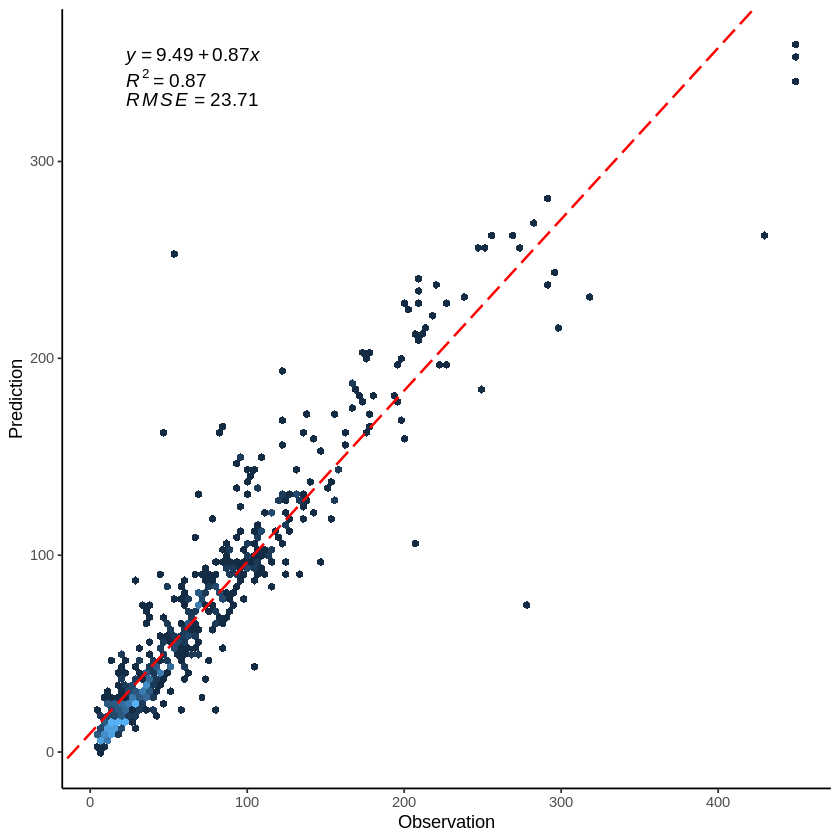

In [24]:
#install.packages("hexbin")
#library(hexbin)
plot_DEML$plot

# **Demostrate the deeper GUI by Liam**

Please install a deeper GUI software first

# Citation

Wenhua Yu, Shanshan Li, Tingting Ye,Rongbin Xu, Jiangning Song, Yuming Guo (2022) Deep ensemble machine learning framework for the estimation of PM2.5 concentrations,Environmental health perspectives: [https://doi.org/10.1289/EHP9752](https://doi.org/10.1289/EHP9752)